ENVIRONMENT SETUP
Installing dependencies...
Dependencies installed!
Preparing Kvasir-SEG dataset...
Dataset already exists! (1000 images, 1000 masks)
Checkpoint sam_vit_b_01ec64.pth already exists!
Dataset Statistics:
  Total valid images: 1000
  Training: 699
  Validation: 150
  Test: 151
Loading original model...
Loading SAM vit_b...


/home/luusamp/gits/SAM-finetune/venv/lib/python3.13/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


  Trainable parameters: 4,058,340 / 93,735,472 (4.33%)

Loading fine-tuned model...
Loading SAM vit_b...
  Trainable parameters: 4,058,340 / 93,735,472 (4.33%)
Model loaded from: outputs/best_model.pth
MODEL COMPARISON: Original vs Fine-tuned

Evaluating Original Model...



Evaluating Fine-tuned Model...



RESULTS COMPARISON
Metric          Original        Fine-tuned      Improvement    
------------------------------------------------------------
Loss            0.1662          0.0646                 -0.1016
IoU             0.7966          0.8848                 +0.0882
Dice            0.8712          0.9348                 +0.0636

Random Example Prediction:
------------------------------------------------------------
Original - IoU: 0.8810 | Dice: 0.9367
Fine-tuned - IoU: 0.9541 | Dice: 0.9765
Improvement - IoU: +0.0731 | Dice: +0.0398


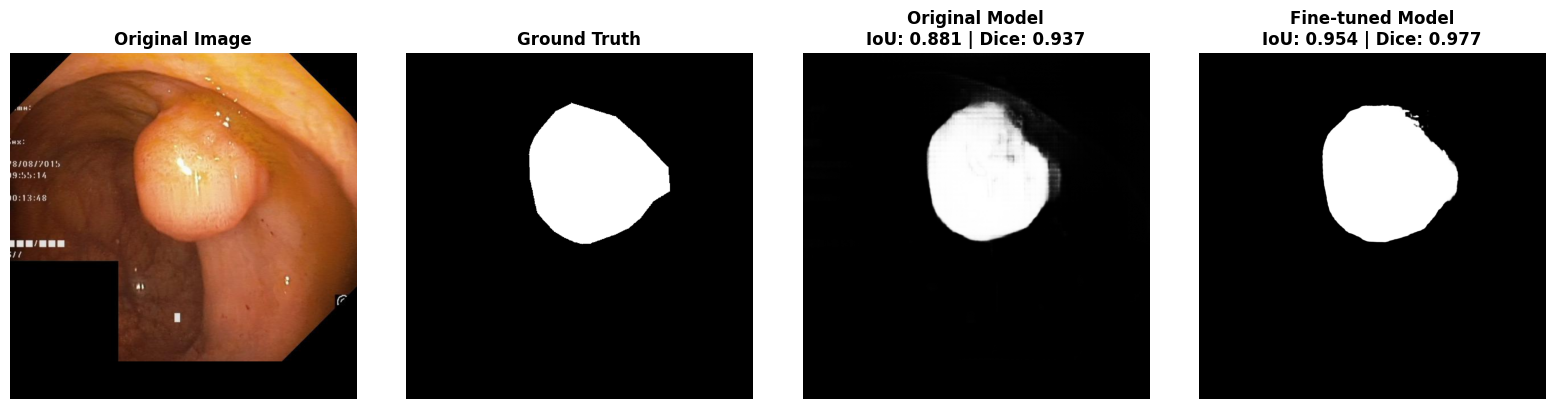

In [1]:
from model.config import Config
from model.dataloaders import prepare_data_splits, create_data_loaders
from model.sam_model import SAMFineTuner
from model.evaluation import compare_models

# Initialize configuration
config = Config()

# Prepare data splits and create test loader
splits = prepare_data_splits(config.DATA_DIR, config.TRAIN_SPLIT, config.VAL_SPLIT)
_, _, test_loader = create_data_loaders(config, splits)

# Create original model (pre-trained, no fine-tuning)
print("Loading original model...")
model_original = SAMFineTuner.create_original(config)

# Load fine-tuned model
print("\nLoading fine-tuned model...")
model_finetuned = SAMFineTuner(config).load('outputs/best_model.pth')

# Compare models
results = compare_models(model_original, model_finetuned, test_loader, show_example=True)